Weather Predictor by Timothy Gunn <br> July 24th, 20245 <br>
The goal of this program is to take 7 days worth of weather data as an input (i.e. high temperature, low temperature, humidity) and predict the average temperature on the 8th day using a multi-layer perceptron created using only NumPy and SciPy (No PyTorch or TensorFlow). <br> <br>
This program is broken up into two major portions: The first implements keeps the MLP in relatively simple way with one hidden layer and a ReLU activation functio. The second implements a more complex MLP with batch normalization, GeLU activation, residual connections, layer abstraction and L2 regularization in hopes of making the model more robust.




In [ ]:
#Importing necessary libaries
!pip install meteostat

import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily
from scipy.stats import norm

Below is the first implentation: An MLP with only 1 hidden layer that uses ReLU for its activation function

loss:  0.25963158149906046
loss:  0.02968303224144691
loss:  0.02592744445288809
loss:  0.022990174035269838
loss:  0.020722880684245774
loss:  0.01891016159534988
loss:  0.017377500728554245
loss:  0.01606489427546961
loss:  0.014973686400700967
loss:  0.014060465134442653


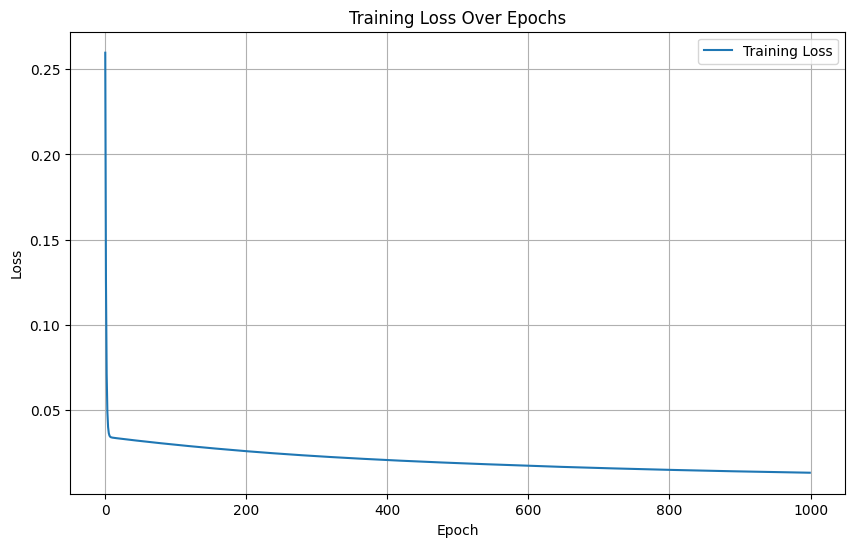

Test MSE: 0.010698308616692902


In [ ]:
#Define city and date range for weather data
city = Point(38.6274, -90.1982)
startDate = datetime(2022, 1, 1)
endDate = datetime(2024, 12, 31)

#Fetch weather data and drop columns that either have missing values or are mostly zeros
weatherData = Daily(city, startDate, endDate).fetch()
weatherData = weatherData.dropna(axis=1).drop(columns='snow')

#Normalize the data using min-max normalation (all values range from 0 to 1)
normalizedData = (weatherData - weatherData.min()) / (weatherData.max() - weatherData.min())

#Set up a sliding window and a target feature
windowSize = 7
target = 'tavg'

#Create input/output pairs
X = []
y = []

for i in range(windowSize, len(normalizedData)):
  #Get features from the 7 day window
  window = normalizedData.iloc[i-windowSize:i].values.astype(float)
  #Get the average tempeature on the 8th day
  targetVal = normalizedData.iloc[i][target]
  #Ensure the matrix is 1D before appending
  X.append(window.flatten())
  #Append corresponding target value
  y.append(targetVal)

#Convert the lists to NumPy arrays
X = np.array(X)
y = np.array(y)

#Split into training and testing data sets (must use a split index since the data is continuous)
splitIndex = int(len(X) * .8)

X_train = X[:splitIndex]
y_train = y[:splitIndex]

X_test = X[splitIndex:]
y_test = y[splitIndex:]

#Create the MLP class
class MLP:
  def __init__(self, inputDimension, hiddenDimension, outputDimension):
    #Initialize the weights and biases of each layers
    self.w1 = np.random.randn(inputDimension, hiddenDimension) * np.sqrt(2 / inputDimension)
    self.b1 = np.zeros((1, hiddenDimension))
    self.w2 = np.random.randn(hiddenDimension, outputDimension) * np.sqrt(2 / hiddenDimension)
    self.b2 = np.zeros((1, outputDimension))

  #Define ReLU to set all negative values to 0
  def ReLU(self, x):
    return np.maximum(0, x.astype(float))

 #Define ReLU derivative for backpropagation
  def ReLUDerivative(self, x):
    return (x > 0).astype(float)


  #Define the forward pass of the MLP to return a temperatue prediction
  def forwardPass(self, X):
    self.Z1 = X @ self.w1 + self.b1
    self.A1 = self.ReLU(self.Z1)
    self.Z2 = self.A1 @ self.w2 + self.b2
    return self.Z2

  #Define the loss function for training (Mean Squared Error)
  def computeLoss(self, y_predicted, y_actual):
    return np.mean((y_predicted - y_actual) ** 2)

  #Perform backpropagation (calculating the new gradients) and gradient descent(updating the weights
  #during the backward pass
  def backwardPass(self, X, y_actual, y_predicted, lr=.01):
    #Backpropagation:
    n = X.shape[0]

    dZ2 = (y_predicted - y_actual) / n
    dw2 = self.A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ self.w2.T
    dZ1 = dA1 * self.ReLUDerivative(self.Z1)
    dw1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    #Gradient descent:
    self.w1 -= lr * dw1
    self.b1 -= lr * db1
    self.w2 -= lr * dw2
    self.b2 -= lr * db2

  #Predict values using the forward pass
  def predict(self, X):
    return self.forwardPass(X)

  #Define the training sequence for the model
  def fit(self, X, y, epochs=1000, lr=.01):
    y = np.array(y).astype(float).reshape(-1, 1)
    trainingLosses = []

    #Perform a forward pass, compute the loss, and then update the weights during the backward pass
    for epoch in range(epochs):
      y_predicted = self.predict(X)
      loss = self.computeLoss(y_predicted, y)
      trainingLosses.append(loss)
      self.backwardPass(X, y, y_predicted, lr)

      #Display loss during training
      if epoch % 100 == 0:
        print("loss: ", loss)

    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), trainingLosses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()


#Set model parameters
inputDimension = X_train.shape[1]
hiddenDimension = 64
outputDimension = 1

#Instantiate and train model
weatherPredictor = MLP(inputDimension, hiddenDimension, outputDimension)
weatherPredictor.fit(X_train, y_train, epochs=1000, lr=.01)

#Evaluate the model using test data
predictedWeather = weatherPredictor.predict(X_test)
mse = np.mean((predictedWeather.flatten() - y_test) ** 2)
print("Test MSE:", mse)


Below is the second implentation: A more advanced MLP with batch normalization, GeLU activation, residual connections, and L2 regularization. The purpose of adding all of these features is to improve the performance of the model through additional hidden layers while avoiding overfitting to the dataset.

loss:  22.029953314477527
loss:  9.56910267960888
loss:  9.23577930080147
loss:  8.970490572221992
loss:  8.729876231716386
loss:  8.504420743919757
loss:  8.29064591778859
loss:  8.0868563050902
loss:  7.892043597810962
loss:  7.705515086050257


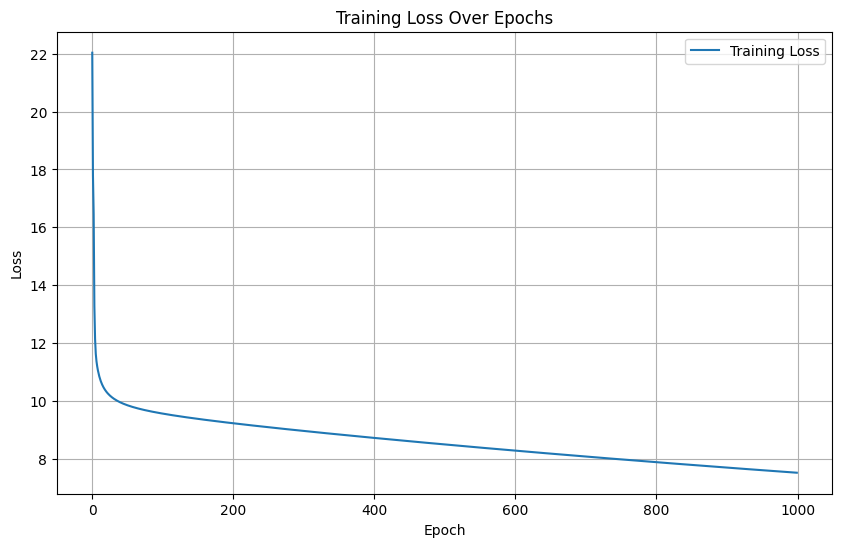

Test MSE: 0.03436807954748817


In [14]:
#Define city and date range for weather data
city = Point(38.6274, -90.1982)
startDate = datetime(2022, 1, 1)
endDate = datetime(2024, 12, 31)

#Fetch weather data and drop columns that either have missing values or are mostly zeros
weatherData = Daily(city, startDate, endDate).fetch()
weatherData = weatherData.dropna(axis=1).drop(columns='snow')

#Normalize the data using min-max normalation (all values range from 0 to 1)
normalizedData = (weatherData - weatherData.min()) / (weatherData.max() - weatherData.min())

#Set up a sliding window and a target feature
windowSize = 7
target = 'tavg'

#Create input/output pairs
X = []
y = []

for i in range(windowSize, len(normalizedData)):
  #Get features from the 7 day window
  window = normalizedData.iloc[i-windowSize:i].values.astype(float)
  #Get the average tempeature on the 8th day
  targetVal = normalizedData.iloc[i][target]
  #Ensure the matrix is 1D before appending
  X.append(window.flatten())
  #Append corresponding target value
  y.append(targetVal)

#Convert the lists to NumPy arrays
X = np.array(X)
y = np.array(y)

#Split into training and testing data sets (must use a split index since the data is continuous)
splitIndex = int(len(X) * .8)

X_train = X[:splitIndex]
y_train = y[:splitIndex]

X_test = X[splitIndex:]
y_test = y[splitIndex:]


class BatchNorm:
  def __init__(self, num_features, momentum=0.9, eps=1e-5):
    #Learnable parameters: gamma for scaling and beta for shifting
    self.gamma = np.ones((1, num_features))
    self.beta = np.zeros((1, num_features))

    #Hyperparameters for updating running statistics and maintaining numerical stability
    self.momentum = momentum
    self.eps = eps

    #Running statistics for inference
    self.runningMean = np.zeros((1, num_features))
    self.runningVar = np.ones((1, num_features))

    #Cache for backpropagation
    self.cache = None

    #Flag to switch between traing (True) and inference (False)
    self.is_training = True

  def forward(self, x):
    if self.is_training:
      #Calculate mean and variance for the current mini-batch
      mu = np.mean(x, axis=0, keepdims=True)
      var = np.var(x, axis=0, keepdims=True)

      #Update running mean and variance (for use during inference)
      self.runningMean = self.momentum * self.runningMean + (1 - self.momentum) * mu
      self.runningVar = self.momentum * self.runningVar + (1 - self.momentum) * var
    else:
      #Use running statistics during inference
      mu = self.runningMean
      var = self.runningVar

    #Normalize the input
    x_normalized = (x - mu) / np.sqrt(var + self.eps)

    #Scale and shift
    out = self.gamma * x_normalized + self.beta

    #Cache values for the backward pass
    self.cache = (x, x_normalized, mu, var)
    return out


  def backward(self, dout):
    #Retrieve cached variables
    x, x_normalized, mu, var = self.cache

    #Batch size
    N = x.shape[0]

    #Gradients for gamma and beta
    dgamma = np.sum(dout * x_normalized, axis=0, keepdims=True)
    dbeta = np.sum(dout, axis=0, keepdims=True)

    #Gradient for normalized input
    dx_normalized = dout * self.gamma

    #Gradients for variance
    dvar = np.sum(dx_normalized * (x - mu) * -0.5 * np.power(var + self.eps, -1.5), axis=0, keepdims=True)

    #Gradients for mean
    dmu = np.sum(dx_normalized * -1 / np.sqrt(var + self.eps), axis=0, keepdims=True) + dvar * -2 * np.sum(x - mu, axis=0, keepdims=True) / N

    #Gradient for input x
    dx = dx_normalized / np.sqrt(var + self.eps) + dvar * 2 * (x - mu) / N + dmu / N

    return dx, dgamma, dbeta

  def set_mode(self, mode):
    #Set training or inference mode
    self.is_training = mode

#Create the MLP class
class MLP:
  def __init__(self, inputDimension, hiddenDimensions, outputDimension, regLambda=.01):
    #Initialize model parameters
    self.weights = [] #List for weight matrices
    self.biases = []  #List for bias vectors
    self.batchNorms =[] #List for BatchNorm objects
    self.activations = [] #List to store activations during the forward pass
    self.Zvalues = [] #List to store the Z values durinf the forward pass
    self.usedResidual = [] #List to track whether residuals were used in each layer

    #Combine input, hidden, and output layer dimensions
    layerDimensions = [inputDimension] + hiddenDimensions + [outputDimension]

    #Iterate through each layer except for the input layer
    for i in range(len(layerDimensions) - 1):
      previousDimension = layerDimensions[i] #Number of neurons in the previous layer
      currentDimension = layerDimensions[i+1] #Number of neurons in the current layer

      #Initialize weights
      self.weights.append(np.random.randn(previousDimension, currentDimension) * np.sqrt(2 / previousDimension))

      #Initialize biases to zeros
      self.biases.append(np.zeros((1,currentDimension)))

      #Initiliaze batch normalization for the hidden layers
      if i < len(hiddenDimensions):
        self.batchNorms.append(BatchNorm(currentDimension))


    #Initialize lambda for L2 regularization
    self.regLambda = regLambda

  #Define GeLU activation function
  def GeLU(self, x):
    #The goal is to introduce smoother non-linearity for a deeper network
    return .5 * x * (1 + scipy.special.erf(x / np.sqrt(2)))

  #Define the derivative of the GeLU function for backpropagation
  def GeLUDerivative(self, x):
    #Get CDF and PDF of x
    cdf = norm.cdf(x)
    pdf = norm.pdf(x)

    #Calculate and return derivative
    derivative = cdf + x * pdf
    return derivative

  #Define the forward pass of the MLP to return a temperatue prediction
  def forwardPass(self, X):
    A = X #Initial input into the network

    #Clear lists for activations, Z values, and used residuals
    self.activations = []
    self.Zvalues = []
    self.usedResidual = []

    #Store the input as the first activation
    self.activations.append(A)

    #Iterate over all of the hidden layers
    for i in range(len(self.weights) - 1):
      #Save input activation for use in residual connection
      A_in = A

      #Linear transformation: Z = A @ w + b
      Z = A @ self.weights[i] + self.biases[i]
      self.Zvalues.append(Z)

      #Apply GeLU activation
      A_preBN = self.GeLU(Z)

      #Apply batch normalization
      A_out = self.batchNorms[i].forward(A_preBN)

      #Apply residual connection if the input and output dimensions match
      if A_in.shape[1] == A_out.shape[1]:
        #Add skip connection
        A = A_out + A_in
        self.usedResidual.append(True)
      else:
        #No residual connection used
        A = A_out
        self.usedResidual.append(False)

      #Save activation for backpropagation
      self.activations.append(A)

    #Calculate output layer (No activation)
    Z_Out = A @ self.weights[-1] + self.biases[-1]
    self.Zvalues.append(Z_Out)

    return Z_Out

  #Define the loss function for training (Mean Squared Error)
  def computeLoss(self, y_predicted, y_actual):
    #Calcluate mean squared error (MSE) between prediction and true labels
    MSE = np.mean((y_predicted - y_actual) ** 2)

    #Initialize L2 regularization terms
    L2_weights = 0
    L2_gamma = 0

    #Accumulate the squared L2 norm of each weight matrix
    for weight in self.weights:
      L2_weights += np.sum(weight**2)

    #Accumulate the squared L2 norm of each batch normalization gamma
    for BNlayer in self.batchNorms:
      L2_gamma += np.sum(BNlayer.gamma**2)

    #Total L2 penalty
    L2_total = self.regLambda * (L2_weights + L2_gamma)

    #Total loss is MSE plus regularization penalty
    return MSE + L2_total

  #Perform backpropagation (calculating the new gradients) and gradient descent(updating the weights
  #during the backward pass
  def backwardPass(self, X, y_actual, y_predicted, lr=.01):
    #Batch size
    n = X.shape[0]

    #Initialize gradient containers for weights, biases, and batch normalization parameters
    dws = [None] * len(self.weights)
    dbs = [None] * len(self.biases)
    dGammas = [None] * len(self.batchNorms)
    dBetas = [None] * len(self.batchNorms)

    #Compute gradient of the loss with respect to the final output (MSE)
    dZ = (y_predicted - y_actual) / n

    #Gradients for the output layer (no activation)
    inputToLastLayer = self.activations[-1]
    dws[-1] = inputToLastLayer.T @ dZ + 2 * self.regLambda * self.weights[-1]
    dbs[-1] = np.sum(dZ, axis=0, keepdims=True)

    #Backpropagate into last hidden layer
    dA = dZ @ self.weights[-1].T

    #Backpropagate through all hidden layers
    for i in reversed(range(len(self.weights) - 1)):
      #Input to a given layer (for residual connections)
      A_in = self.activations[i]

      #Current gradient from downstream
      dA_residual_main = dA

      #Backpropgate through BatchNorm and store gradients of gamma and beta
      dx_normalized, dgamma, dbeta = self.batchNorms[i].backward(dA_residual_main)

      #Backpropagate through the GeLU activation
      dZ = dx_normalized * self.GeLUDerivative(self.Zvalues[i])

      #Compute gradients for weights and biases, including L2 regularization
      dws[i] = self.activations[i].T @ dZ + 2 * self.regLambda * self.weights[i]
      dbs[i] = np.sum(dZ, axis=0, keepdims=True)
      dGammas[i] = dgamma
      dBetas[i] = dbeta

      #If a residual connection was used, add its contribution to the gradient
      if self.usedResidual[i]:
        dA = (dZ @ self.weights[i].T) + dA #Include skip connection
      else:
        dA = (dZ @ self.weights[i].T)

    #Gradient descent parameter update
    for i in range(len(self.weights)):
      self.weights[i] -= lr * dws[i]
      self.biases[i] -= lr * dbs[i]
      if i < len(self.batchNorms):
        self.batchNorms[i].gamma -= lr * dGammas[i]
        self.batchNorms[i].beta -= lr * dBetas[i]


  #Predict values using the forward pass
  def predict(self, X):
    #Switch all BatchNorm layers to inference mode so that batch statistics aren't updated
    for BNLayer in self.batchNorms:
      BNLayer.set_mode(False)

    #Perform forward pass to gather predictions
    predictions = self.forwardPass(X)

    #After prediction, restore BatchNorm layers to training mode and return the predictions
    for BNLayer in self.batchNorms:
      BNLayer.set_mode(True)
    return predictions

  #Define the training sequence for the model
  def fit(self, X, y, epochs=1000, lr=.01):
    #Ensure the target labels are in float format and reshaped to a column vector
    y = np.array(y).astype(float).reshape(-1, 1)

    #Initialize list for training losses (for graphing)
    trainingLosses = []

    #Set all BatchNorm layers to training mode
    for BNLayer in self.batchNorms:
      BNLayer.set_mode(True)

    #Perform a forward pass, compute the loss, and then update the weights during the backward pass
    for epoch in range(epochs):
      y_predicted = self.forwardPass(X)
      loss = self.computeLoss(y_predicted, y)
      self.backwardPass(X, y, y_predicted, lr)
      trainingLosses.append(loss)

      #Display loss during training
      if epoch % 100 == 0:
        print("loss: ", loss)

    # Plotting the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), trainingLosses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()


#Set model parameters
inputDimension = X_train.shape[1]
hiddenDimensions = [64] * 5
outputDimension = 1

#Instantiate and train model
weatherPredictor = MLP(inputDimension, hiddenDimensions, outputDimension)
weatherPredictor.fit(X_train, y_train, epochs=1000, lr=.01)

#Evaluate the model using test data
predictedWeather = weatherPredictor.predict(X_test)
mse = np.mean((predictedWeather.flatten() - y_test) ** 2)
print("Test MSE:", mse)